In [1]:
%load_ext lab_black

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import Affine2D
from matplotlib.lines import Line2D

In [3]:
# Metadata saved to output plots
METADATA = {"Contributor": "Alexander Gude", "Rights": "CC-BY-SA 4.0"}

In [4]:
# Show plots inline
%matplotlib inline

In [5]:
COLORS = {
    "zillow": "#006AFF",
    "redfin": "#E62E2E",
    "xome": "#FF5C39",
    "realtor.com": "#D92228",
}

# Helper functions

In [6]:
# We should be able to just set rcParams, expect Jupyter has a bug:
# https://github.com/jupyter/notebook/issues/3385
#
# So we have to call this function every time we want to plot.


def setup_plot(title=None, xlabel=None, ylabel=None):
    """Set up a simple, single pane plot with custom configuration.

    Args:
        title (str, optional): The title of the plot.
        xlabel (str, optional): The xlabel of the plot.
        ylabel (str, optional): The ylabel of the plot.

    Returns:
        (fig, ax): A Matplotlib figure and axis object.

    """
    # Plot Size
    plt.rcParams["figure.figsize"] = (12, 7)  # (Width, height)

    # Text Size
    SMALL = 12
    MEDIUM = 16
    LARGE = 20
    HUGE = 28
    plt.rcParams["axes.titlesize"] = HUGE
    plt.rcParams["figure.titlesize"] = HUGE
    plt.rcParams["axes.labelsize"] = LARGE
    plt.rcParams["legend.fontsize"] = LARGE
    plt.rcParams["xtick.labelsize"] = MEDIUM
    plt.rcParams["ytick.labelsize"] = MEDIUM
    plt.rcParams["font.size"] = SMALL

    # Legend
    plt.rcParams["legend.frameon"] = True
    plt.rcParams["legend.framealpha"] = 1
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.edgecolor"] = "black"

    # Figure output
    plt.rcParams["savefig.dpi"] = 300

    # Make the plol
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Make the title and label area opaque instead of transparent
    fig.patch.set_facecolor(ax.get_facecolor())

    return fig, ax

In [7]:
def draw_colored_legend(ax, loc="best"):
    """Draw a legend for the plot with the text colored to match the points.

    Args:
        ax (matplotlib axis): The axis to draw on.

    """
    # Draw a legend where there is no space around the line/point so
    # that the text is in the right place when we turn off the line/point.
    legend = ax.legend(handlelength=0, handletextpad=0, loc=loc)

    handles = legend.legendHandles
    texts = legend.get_texts()
    for handle, text in zip(handles, texts):
        # Change the color of the text to match the line or points
        try:
            # Points and some other objects have this
            color = handle.get_facecolor()[0]
        except AttributeError:
            # Lines have this
            color = handle.get_color()

        text.set_color(color)

        # Turn off the point
        handle.set_visible(False)

In [8]:
def save_plot(fig, filename):
    """Save the plot with metadata and tight layout.

    Args:
        fig (matplotlib figure): The figure to save.
        filename (str): The loction to save the file to.

    """
    metadata = METADATA

    fig.savefig(
        fname=f"{filename}",
        bbox_inches="tight",
        metadata=metadata,
    )

In [9]:
def number_formatter(number, pos=None):
    """Convert a number into a human readable format.

    Via https://flynn.gg/blog/better-matplotlib-charts/"""
    number /= 1000.0

    return f"${number:,.0f}K"

# Data

In [10]:
df = pd.read_csv(
    "./home_price_estimate_timeseries_data.csv", header=0, index_col=False, parse_dates=["date"]
).sort_values(["date", "company"])

# Convert dollars to float
df["estimate"] = df["estimate"].replace("\D", "", regex=True).astype(float)


df

,company,date,estimate,notes
1,redfin,2022-02-14,1189113.0,NaN
0,zillow,2022-02-14,883000.0,NaN
2,list,2022-02-20,998000.0,list
3,redfin,2022-02-20,1005749.0,NaN
4,redfin,2022-02-25,1143186.0,NaN
...,...,...,...,...
69,zillow,2022-04-07,1280200.0,NaN
72,redfin,2022-04-09,1294053.0,NaN
71,zillow,2022-04-09,1288400.0,NaN
74,redfin,2022-04-10,1294053.0,NaN


In [11]:
list_price = df[df["company"] == "list"]["estimate"].item()
sold_price = df[df["company"] == "sold"]["estimate"].item()

rounded_list_price = round(list_price / 1000)
rounded_sold_price = round(sold_price / 1000)

list_date = df[df["company"] == "list"]["date"].item()
pending_date = df[df["company"] == "pending"]["date"].item()
sold_date = df[df["company"] == "sold"]["date"].item()

list_price, sold_price

(998000.0, 1275000.0)

In [12]:
companies_df = df[df["company"].isin(["zillow", "redfin"])]

companies_df

,company,date,estimate,notes
1,redfin,2022-02-14,1189113.0,NaN
0,zillow,2022-02-14,883000.0,NaN
3,redfin,2022-02-20,1005749.0,NaN
4,redfin,2022-02-25,1143186.0,NaN
5,zillow,2022-02-25,1062600.0,NaN
...,...,...,...,...
69,zillow,2022-04-07,1280200.0,NaN
72,redfin,2022-04-09,1294053.0,NaN
71,zillow,2022-04-09,1288400.0,NaN
74,redfin,2022-04-10,1294053.0,NaN


In [13]:
company_names = {c.capitalize() for c in companies_df["company"]}

company_names

{'Redfin', 'Zillow'}

In [14]:
color_list = [COLORS.get(company.lower()) for company in company_names]

color_list

['#006AFF', '#E62E2E']

# Plotting

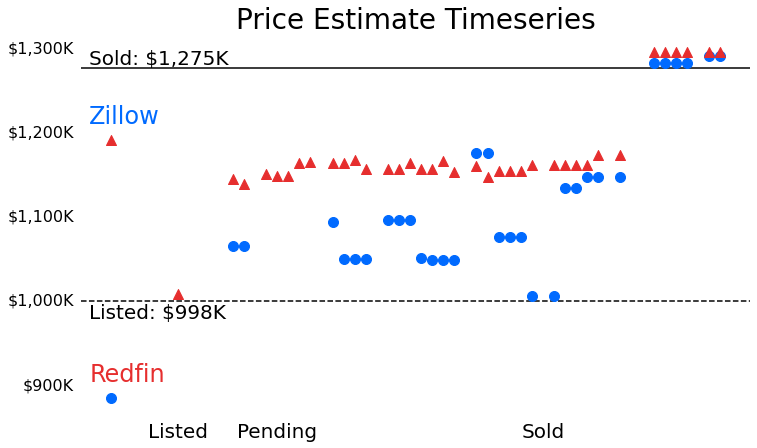

In [15]:
fig, ax = setup_plot("Price Estimate Timeseries")

# Format y-axis for dollars
ax.yaxis.set_major_formatter(FuncFormatter(number_formatter))

# Scatter plot uses a different size that is the square of the marker size
marker_size = 10
scatter_size = marker_size ** 2
markers = ["o", "^"]

# Plot estimates
for company_name, color, marker in zip(company_names, color_list, markers):
    company_df = companies_df[companies_df["company"] == company_name.lower()]

    ax.scatter(
        x=company_df["date"].values,
        y=company_df["estimate"].values,
        color=color,
        s=scatter_size,
        label=company_name,
        marker=marker,
    )

# Draw list and sales prices
ax.axhline(y=list_price, color="black", zorder=-1, linestyle="dashed")
ax.axhline(y=sold_price, color="black", zorder=-1)

text_x_date = pd.to_datetime("2022-02-12")
ax.text(
    x=text_x_date,
    y=list_price - 3000,
    s=f"Listed: ${rounded_list_price:,.0f}K",
    fontsize=20,
    verticalalignment="top",
)
ax.text(
    x=text_x_date,
    y=sold_price,
    s=f"Sold: ${rounded_sold_price:,.0f}K",
    fontsize=20,
    verticalalignment="bottom",
)

# Drawing list, pending, and sold dates
# ax.axvline(x=list_date, color="black", zorder=-1)
# ax.axvline(x=pending_date, color="black", zorder=-1)
# ax.axvline(x=sold_date, color="black", zorder=-1)
# ax.axvline(x=pd.to_datetime("2022-04-02"), color="green")  # Next Saturday
# ax.axvline(x=pd.to_datetime("2022-02-25"), color="green")  # Next Saturday

# Draw legend by points
legend_x_date = pd.to_datetime("2022-02-12")
offset = 20_000
for company_name, color, y in zip(company_names, color_list, [1_189_113, 883_000]):
    ax.text(
        x=legend_x_date,
        y=y + offset,
        s=company_name,
        fontsize=24,
        color=color,
    )

# Adjust x-axis labels
ax.xaxis.set_ticks_position("none")  # Remove the line from ticks
ax.yaxis.set_ticks_position("none")

ax.set_xticks([list_date, pending_date, sold_date])
ax.set_xticklabels(["Listed", "Pending", "Sold"])
ax.tick_params(axis="x", labelsize=20)

sns.despine(top=True, bottom=True, left=True, right=True)

for ext in ("png", "svg"):
    save_plot(fig, f"/tmp/home_price_estimate_timeseries_comparison.{ext}")